In [2]:
import scanpy as sc
import bbknn  # pip install bbknn
import matplotlib.pyplot as plt

# 1. Read both datasets --------------------------------------
adata_multi = sc.read_h5ad("/Users/apple/Desktop/KB/data/Celltagging-multi_Fibroblast/celltagging_multi_fibroblast.h5ad")
adata_tag_log   = sc.read_h5ad("/Users/apple/Desktop/KB/data/BiddyData/biddy_6534_2000_norm_log.h5ad")   
adata_tag = sc.read_h5ad("/Users/apple/Desktop/KB/data/BiddyData/Biddy_scvi.h5ad") # the data feed into scVI is raw count

adata_multi.layers["counts"] = adata_multi.X.copy()
adata_tag.layers["counts"]   = adata_tag.X.copy()

In [2]:
# Compute per‐cell QC metrics
adata_multi.var['mt'] = adata_multi.var_names.str.startswith('MT-')  # or 'mt-' depending on your organism
sc.pp.calculate_qc_metrics(
    adata_multi,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

In [4]:
# 1) Filter out low‐count / low‐complexity cells
sc.pp.filter_cells(adata_multi, min_counts=1000)     # e.g. ≥1 000 total UMIs
sc.pp.filter_cells(adata_multi, min_genes=200)       # e.g. ≥200 genes detected
adata_multi = adata_multi[adata_multi.obs.pct_counts_mt < 5, :]  # < 5% mitochondrial

: 

In [3]:
adata_multi.obs["assigned_lineage"]

B4D3-RNA-r1-1_AAACCCAAGCCTCTCT-1              NaN
B4D3-RNA-r1-1_AAACCCACAAAGTATG-1              NaN
B4D3-RNA-r1-1_AAACCCACACTCTAGA-1    Lineage:29424
B4D3-RNA-r1-1_AAACCCACAGCAGAAC-1              NaN
B4D3-RNA-r1-1_AAACCCATCCACGGAC-1              NaN
                                        ...      
D0HF2-RNA_TTTGTCATCACCGTAA-1                  NaN
D0HF2-RNA_TTTGTCATCACTTCAT-1                  NaN
D0HF2-RNA_TTTGTCATCCCATTAT-1                  NaN
D0HF2-RNA_TTTGTCATCGCTTAGA-1                  NaN
D0HF2-RNA_TTTGTCATCTTTACAC-1                  NaN
Name: assigned_lineage, Length: 226614, dtype: category
Categories (18916, object): ['Lineage:9', 'Lineage:116', 'Lineage:118', 'Lineage:121', ..., 'Lineage:66818', 'Lineage:66819', 'Lineage:66821', 'Lineage:66824']

In [3]:
# 1) drop all cells without an assigned lineage
mask_has_lineage = adata_multi.obs['assigned_lineage'].notnull()
adata_lineaged = adata_multi[mask_has_lineage].copy()
print(f"Kept {adata_lineaged.n_obs} cells with any lineage (dropped {adata_multi.n_obs - adata_lineaged.n_obs}).")


Kept 47302 cells with any lineage (dropped 179312).


In [4]:
# 2) compute lineage sizes
lineage_sizes = adata_lineaged.obs['assigned_lineage'].value_counts()

In [5]:
# 3) pick only the “big” lineages (size > 4)
valid_lineages = lineage_sizes[lineage_sizes > 4].index
adata_filtered = adata_lineaged[adata_lineaged.obs['assigned_lineage'].isin(valid_lineages)].copy()

print(f"Filtered out all lineages ≤ 4 cells; now have {adata_filtered.n_obs} cells in {len(valid_lineages)} lineages.")

Filtered out all lineages ≤ 4 cells; now have 22238 cells in 1367 lineages.


In [6]:
adata_multi = adata_filtered
adata_multi.X.shape

(22238, 31761)

In [2]:
import numpy as np
from scipy import sparse

if sparse.issparse(adata_multi.X):
    vals = adata_multi.X.data
else:
    vals = adata_multi.X.ravel()

print("min, max, mean, median:", 
      np.min(vals), np.max(vals), np.mean(vals), np.median(vals))

all_int = np.all(vals.astype(int) == vals)
print("all values integer? →", all_int)

print("layers:", list(adata_multi.layers.keys()))
if adata_multi.raw is not None:
    raw_vals = adata_multi.raw.X.data if sparse.issparse(adata_multi.raw.X) else adata_multi.raw.X.ravel()
    print("adata.raw → min/max:", raw_vals.min(), raw_vals.max())

min, max, mean, median: 1 18191 4.843119479624152 1.0
all values integer? → True
layers: []


In [7]:
# 1. Harmonize gene sets & annotate batch --------------------
common = adata_multi.var_names.intersection(adata_tag.var_names)
print("number of overlapped genes:", len(common))
adata_multi = adata_multi[:, common].copy()
adata_tag   = adata_tag[:,   common].copy()

adata_multi.obs['batch'] = 'multi'
adata_tag.obs['batch']   = 'tag'

number of overlapped genes: 1960


In [8]:
# 2. Concatenate into one AnnData -----------------------------
adata = adata_multi.concatenate(
    adata_tag,
    batch_key='batch',
    batch_categories=['multi','tag'],
    index_unique=None
)

/var/folders/ql/mhz506t52bjgn30w6f4wqhv40000gn/T/ipykernel_5227/1681444087.py:2: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata = adata_multi.concatenate(


In [11]:
adata.write_h5ad("integrated_for_scVI.h5ad")

In [19]:
adata = sc.read_h5ad("/Users/apple/Desktop/KB/data/Cell_tag-Cell_tag_multi_integrated/integrated_for_scVI.h5ad")

In [20]:
# 3. Normalize, log, select HVGs -----------------------------
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(
    adata,
    flavor='seurat_v3',
    n_top_genes=2000,
    batch_key='batch'
)
adata = adata[:, adata.var.highly_variable].copy()


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:61: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


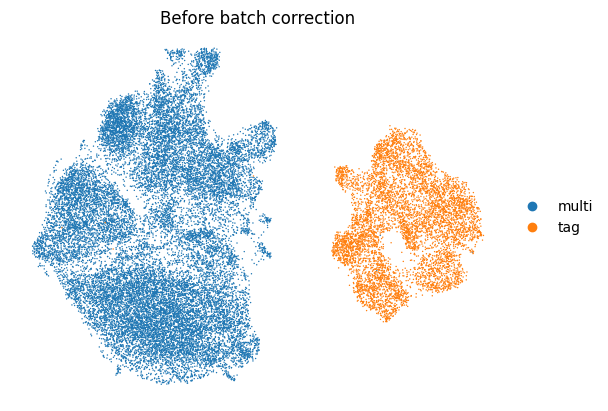

In [21]:
# 4. Scale & run PCA ------------------------------------------
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

# 5. Pre‐correction neighbors & UMAP --------------------------
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color='batch',
    title='Before batch correction',
    frameon=False
)
plt.show()

In [ ]:
# # 6. Batch correction with BBKNN -------------------------------
# bbknn.bbknn(
#     adata,
#     batch_key='batch',
#     n_pcs=30
# )
# # recompute UMAP on BBKNN graph
# sc.tl.umap(adata)
# sc.pl.umap(
#     adata,
#     color='batch',
#     title='After BBKNN correction',
#     frameon=False
# )
# plt.show()

# # 7. (Optional) Save BBKNN‐corrected object --------------------
# # adata.write_h5ad("integrated_bbknn.h5ad")

In [22]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.0.8,...,cluster,monocle_state,pseudotime,CellTagD0_85k,CellTagD3_85k,CellTagD13_85k,CellTagD0_48k,CellTagD3_48k,CellTagD13_48k,clone_id
B4D3-RNA-r1-1_AAAGGATAGGCTCCCA-1,B4D3-RNA-r1-1,24694.0,4877.0,2.040982,0.076409,0.637109,G2M,G2M,-0.602379,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AAAGTCCAGACCTCAT-1,B4D3-RNA-r1-1,59444.0,7081.0,2.701702,0.007553,0.452994,G2M,G2M,-0.471895,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AAAGTCCTCGCCTTTG-1,B4D3-RNA-r1-1,57780.0,6348.0,2.225684,-0.109437,-0.155449,G1,G1,0.039002,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AACAAAGGTATGCGTT-1,B4D3-RNA-r1-1,80636.0,7845.0,2.397192,0.130052,0.047211,S,S,0.074748,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AACCAACAGGTTTGAA-1,B4D3-RNA-r1-1,2037.0,1090.0,2.798233,0.086488,0.023384,S,S,0.058286,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HF2_TTCTTAGAGCGACGTA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,2,0.509046,2657.0,NaN,NaN,2657.0,NaN,NaN,2657.0
HF2_TTCCCAGGTGATGATA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,2,0.530828,2367.0,2514.0,NaN,2367.0,2514.0,NaN,2367.0
HF2_TTCTCCTCATGAACCT_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5,2,0.403314,2490.0,2042.0,NaN,2490.0,2042.0,NaN,2490.0
HF2_TTGGAACCAAGAAAGG_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,1.029464,2764.0,2525.0,NaN,2764.0,2525.0,NaN,2764.0


/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


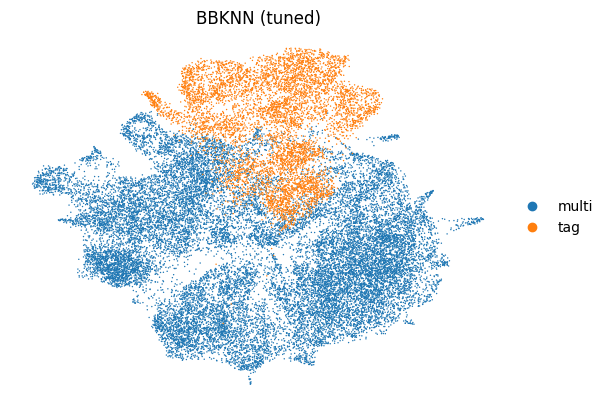

In [ ]:
# stronger mixing
bbknn.bbknn(
    adata,
    batch_key='batch',
    n_pcs=50,                  # more dimensions
    neighbors_within_batch=10,  # more same-batch neighbors
)
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch', title='BBKNN (tuned)', frameon=False)

# adata.write_h5ad("integrated_bbknn.h5ad")

/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/opt/anaconda3/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


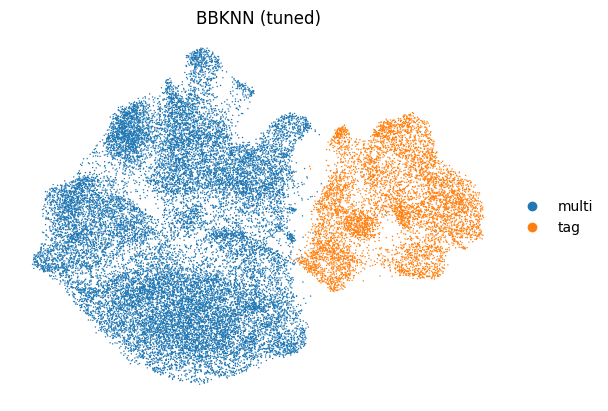

In [22]:
# stronger mixing
bbknn.bbknn(
    adata,
    batch_key='batch',
    n_pcs=30,                  # more dimensions
    neighbors_within_batch=30,  # more same-batch neighbors
)
sc.tl.umap(adata)
sc.pl.umap(adata, color='batch', title='BBKNN (tuned)', frameon=False)

# adata.write_h5ad("integrated_bbknn.h5ad")

In [ ]:
adata.

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,S.Score,G2M.Score,Phase,old.ident,CC.Difference,RNA_snn_res.0.8,...,monocle_state,pseudotime,CellTagD0_85k,CellTagD3_85k,CellTagD13_85k,CellTagD0_48k,CellTagD3_48k,CellTagD13_48k,clone_id,n_genes
B4D3-RNA-r1-1_AAAGGATAGGCTCCCA-1,B4D3-RNA-r1-1,24694.0,4877.0,2.040982,0.076409,0.637109,G2M,G2M,-0.602379,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AAAGTCCAGACCTCAT-1,B4D3-RNA-r1-1,59444.0,7081.0,2.701702,0.007553,0.452994,G2M,G2M,-0.471895,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AAAGTCCTCGCCTTTG-1,B4D3-RNA-r1-1,57780.0,6348.0,2.225684,-0.109437,-0.155449,G1,G1,0.039002,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AACAAAGGTATGCGTT-1,B4D3-RNA-r1-1,80636.0,7845.0,2.397192,0.130052,0.047211,S,S,0.074748,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
B4D3-RNA-r1-1_AACCAACAGGTTTGAA-1,B4D3-RNA-r1-1,2037.0,1090.0,2.798233,0.086488,0.023384,S,S,0.058286,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HF2_TTCTTAGAGCGACGTA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0.509046,2657.0,NaN,NaN,2657.0,NaN,NaN,2657.0,2038.0
HF2_TTCCCAGGTGATGATA_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0.530828,2367.0,2514.0,NaN,2367.0,2514.0,NaN,2367.0,3610.0
HF2_TTCTCCTCATGAACCT_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,0.403314,2490.0,2042.0,NaN,2490.0,2042.0,NaN,2490.0,3993.0
HF2_TTGGAACCAAGAAAGG_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,1.029464,2764.0,2525.0,NaN,2764.0,2525.0,NaN,2764.0,3521.0
